## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 7. Востановление пропусков и прогноз значений временного ряда.**


#### **7.1 Аналитечкие методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с базовыми, аналитическими методами восстановления временных рядов.
Для выполнения данного пункта из каждой группы методов, представленных в ***табл. 7.1*** вам необходимо выбрать по одному методу восстановления ряда. При работе с первой группой, вам необходимо самостоятельно реализовать выбранный метод.  

**Табл. 7.1** - Группы аналитических методов восстановления.
№|Название группы|Модели и методы|
--|----|----|
1|Заполнение существующими значениями ряда|Средним, медианной, Hot-Deck|
2|Заполнение на основе близки значений|[Интерполяция](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html),  [KNNi](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)|
3|На основе матричных разложений|[CD-Rec](#Fixme:Дат ссылку), [SVD](https://pypi.org/project/fancyimpute/)|

##### 7.1.1 Загрузка и подготовка данных
В данной работе вы будете использовать следующие наборы данных:
1. фывфыв
2. фывфв

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [4]:

path_data = Path('datasets')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,0]
print(madrid.shape)

(25000,)


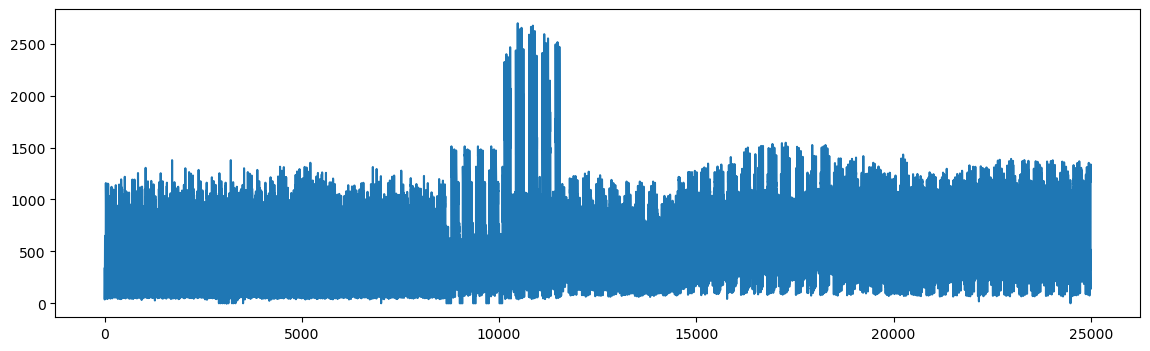

In [5]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(madrid[:])
plt.show()

Самостоятельно реализуйте функцию, принимающую на вход многомерный временной ряд и возвращающий:
1. Все подпоследовательности временного ряда, в которых некоторые значения временного ряда были заменены nan значениями.
2. Индексы пропущенных значейни
   
Процен пппроущенных значений должен регулироваться тедельным параметром.


In [6]:
import copy
import torch
import random

random.seed(0)

In [7]:
def add_nan(x, percent = 0.25):
    x_with_nan = copy.deepcopy(x)
    nan_len = x.shape[0] * percent
    nan_counter = 0
    x_with_nan_index = []

    for i in range(x_with_nan.shape[0]):
        if nan_counter <= nan_len and random.randint(0, 1):
            x_with_nan[i] = np.nan
            nan_counter += 1

    return x_with_nan, np.isnan(x_with_nan)

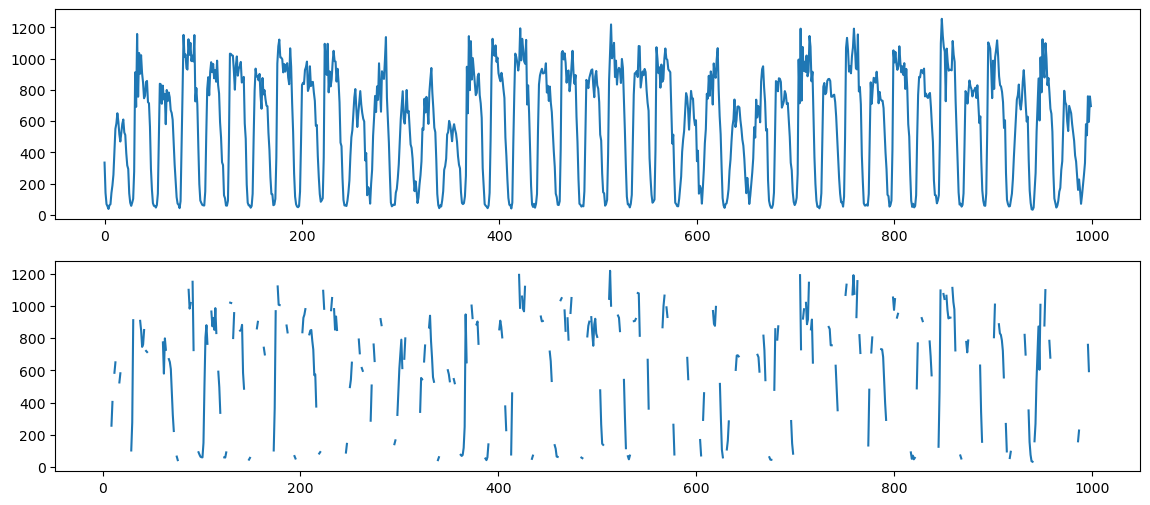

In [8]:
madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_with_nan[:1000])
plt.show()

##### 7.1.2 Заполнение существующими значениями ряда


In [9]:
recovery = {}

In [10]:
madrid_mean = madrid_with_nan.copy()
madrid_mean[index] = np.nanmean(madrid_mean)
recovery['mean'] = madrid_mean

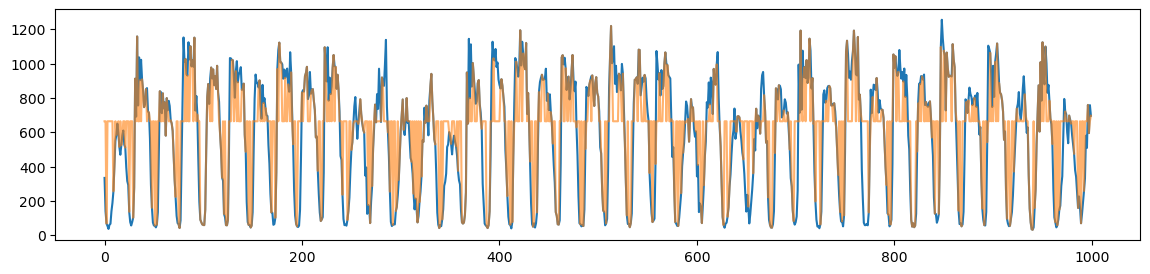

In [11]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_mean[:1000], alpha=0.6)
plt.show()

In [12]:
madrid_median = madrid_with_nan.copy()
madrid_median[index] = np.nanmedian(madrid_median)

In [13]:
recovery['median'] = madrid_median

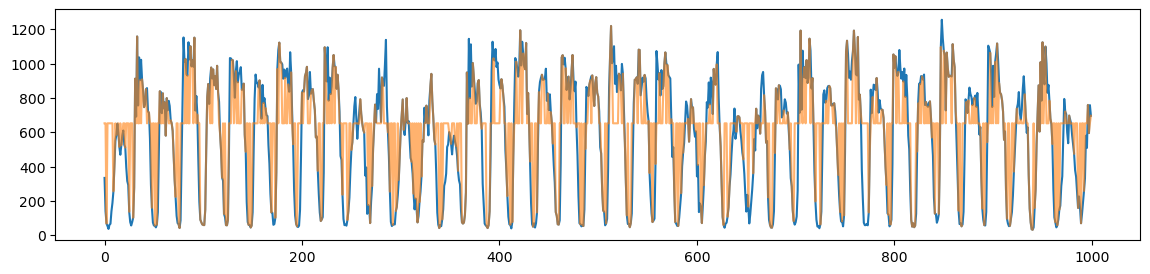

In [14]:
#madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_median[:1000], alpha=0.6)
plt.show()

Самостоятельно реализуйте один метод из первой группы ***табл. 7
.1*** и проведите востановление данных, сохратив результаты востановления.

In [15]:
madrid_with_nan.shape

(25000,)

In [16]:
madrid_with_nan = madrid_with_nan.reshape(-1, 1)
madrid_with_nan.shape

(25000, 1)

In [17]:
# Hot-Deck

def get_not_nan_row(index, i_indx, x, x_indx, step):

    # index - массив индексов
    # i_indx - индекс строки массива индексов, для заполнения которой ищем значения
    # x - массив значений
    # x_indx - индекс строки массива значений, в которой ищем значения
    # step - шаг

    if x.shape[0] <= x_indx and x_indx >= 0:
        return np.nan

    if ~np.isnan(x[x_indx][index[i_indx]]).all():
        return x[x_indx][index[i_indx]]

    return np.nan


def hot_deck(x, index):
    hot_deck = x.copy()

    for i in range(x.shape[0]):
        if index[i].any():

            for j in range(i, x.shape[0]):
                if ~np.isnan(hot_deck[j][index[i]]).any():
                    next_row = hot_deck[j][index[i]]
                    break

            if ~np.isnan(next_row).any():
                hot_deck[i][index[i]] = next_row
            else:
                for j in range(i, 0, -1):
                    if ~np.isnan(hot_deck[j][index[1]]).any():
                        prev_row = hot_deck[j][index[i]]
                        break

                if ~np.isnan(prev_row).any():
                    hot_deck[i][index[i]] = prev_row

    return hot_deck

In [18]:
madrid_hot_deck = hot_deck(madrid_with_nan, index)

In [19]:
recovery['hot_deck'] = madrid_hot_deck

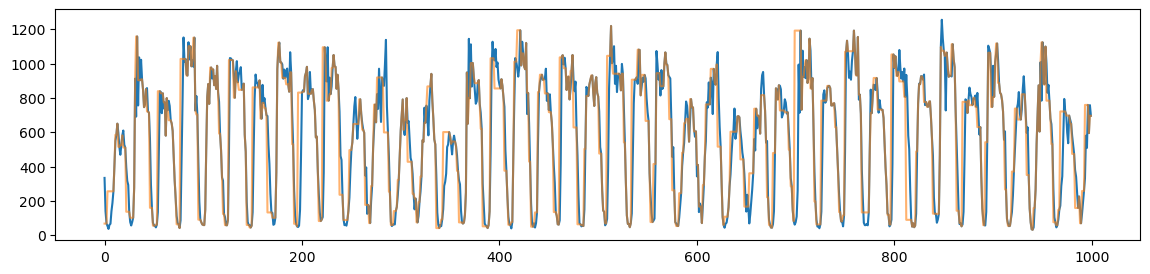

In [20]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_hot_deck[:1000], alpha=0.6)
plt.show()

##### 7.1.3 Заполнение на основе близких значений


Используя документацию одного из методов востановления второй группы ***табл. .1*** и проведите востановление данных, сохратив результаты востановления.

In [21]:
from sklearn.impute import KNNImputer

In [22]:
madrid_with_nan, index = add_nan(madrid)

In [23]:
def rolling_window(a, window, intersection=False):
    # result = torch.zeros(size=(a.shape[0],a.shape[1]))
    returns = []
    if intersection:
        for i in range(0, a.shape[0]-window):
            returns.append(a[i:i + window])
    else:
        for i in range(0, a.shape[0],window):
            returns.append(a[i:i + window])
    return np.stack(returns)

In [24]:
madrid_slice = rolling_window(madrid_with_nan, 100)

imputer = KNNImputer(n_neighbors=10)

madrid_knn_imputer = imputer.fit_transform(madrid_slice)
madrid_knn_imputer = madrid_knn_imputer.ravel()

In [25]:
recovery['knn_imputer'] = madrid_knn_imputer

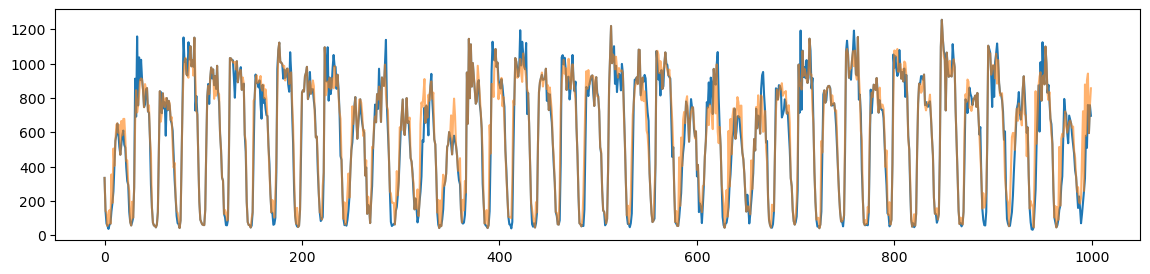

In [26]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_knn_imputer[:1000], alpha=0.6)
plt.show()

##### 7.1.4 Заполнение на матричных преобразований

Используя документацию одного из методов востановления третей группы ***табл. 7.1*** и проведите востановление данных, сохратив результаты востановления.

In [27]:
!pip install fancyimpute

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/38/85/5f46779431dd978f62a1f5bd64df05d9a1418cc50d7294e98bf445e31068/cvxpy-1.4.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cvxopt from https://files.pythonhosted.org/packages/a3/52/2237d72cf007e6c36367ab8a776388a9f13511e4cfa8a71b79101ad6e0fa/cvxopt-1.3.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/154.7 kB ? eta -:--:--
     --------- --------------------------- 41.0/154.7 kB 991.0 kB/s eta 0:00:01
     ----------------- ------------------- 71.7/154.7 kB 787.7 kB/s eta 0:00:01
     ----------------------------------- -- 143.4/154.7 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 154.7/154.7 kB 1.0 MB/s eta 0

In [28]:
from fancyimpute import IterativeSVD

In [29]:
solver = IterativeSVD(rank=2)
madrid_iterative_svd = madrid_slice.copy()
madrid_iterative_svd = solver.fit_transform(madrid_iterative_svd)
madrid_iterative_svd = madrid_iterative_svd.ravel()

[IterativeSVD] Iter 1: observed MAE=344.441842
[IterativeSVD] Iter 2: observed MAE=269.253047
[IterativeSVD] Iter 3: observed MAE=259.911909
[IterativeSVD] Iter 4: observed MAE=257.368365
[IterativeSVD] Iter 5: observed MAE=256.563359
[IterativeSVD] Iter 6: observed MAE=256.298071
[IterativeSVD] Iter 7: observed MAE=256.201140
[IterativeSVD] Iter 8: observed MAE=256.165482
[IterativeSVD] Iter 9: observed MAE=256.151770
[IterativeSVD] Iter 10: observed MAE=256.146407
[IterativeSVD] Iter 11: observed MAE=256.144139


In [30]:
recovery['iterative_svd'] = madrid_iterative_svd

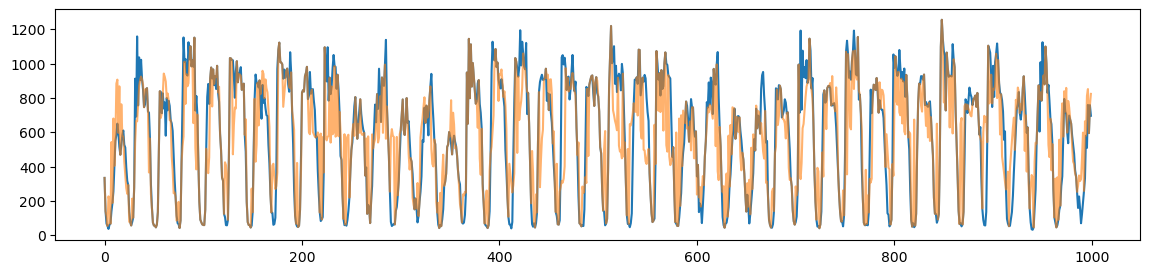

In [31]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_iterative_svd[:1000], alpha=0.6)
plt.show()

##### 7.1.5 Сравнение результатов востановление.


Используя следующие библиотеки(список библиотек) отдельно для каждой группы методов постройте методов основные метрики оценки качества постановления.
На основе метрик отберите лучшие методы постановления метрик и выберите лучшую группу методов. Для лучших методов из каждой группы постройте графики сравнения реальных и восстановленных данных. Объясните результаты и сделайте вывод.



In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
metrics = {}

for method in recovery:
    metrics[method] = mean_squared_error(madrid, recovery[method])

metrics

{'mean': 44645.35770742836,
 'median': 44263.44668,
 'hot_deck': 23214.8272,
 'knn_imputer': 12661.4939212,
 'iterative_svd': 30432.439852753952}

#### **7.2 Нейросетевые методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с некоторыми нейросетевыми методами восстановления временных рядов.
Для выполнения данного пункта вам предстоит самостоятельно реализовать структуру нейросетевой, модели основанной на GRU нейронах и сравнить ее с другими нейросетевыми методами восстановления При сравнение с 3 группой из **табл.7. 2** вам необходимо выбрать **один** метод восстановлени.. Основные блоки обработки данных будут реализованы с использованиме Pytorch. Вам не запрещается использовать для реализации Keras.

**т*ал7 5.2** - Нейросетевые методы восстановления.
№|Название группы|Модели и методы|
--|-------------|----|
1|Линейные нейроны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)|
 2eкрркуретные нейронны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)|
3|Сложные структуры|[SAITS, BRITS, M-RNN](https://github.com/WenjieDu/PyPOTS)|

In [34]:
recovery_nn = {}

In [35]:
def add_nan(x, percent = 0.25):
    x_with_nan = copy.deepcopy(x)
    nan_len = x.shape[0] * x.shape[1] * percent
    nan_counter = 0
    x_with_nan_index = []

    for i in range(x_with_nan.shape[0]):
        for j in range(x_with_nan.shape[1]):
            if nan_counter <= nan_len and random.randint(0, 1):
                x_with_nan[i, j] = np.nan
                nan_counter += 1

    return x_with_nan, np.isnan(x_with_nan)

##### 7.2.1 Загрузка и подготовка данных

In [37]:

path_data = Path('datasets')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,:]
print(madrid.shape)

(25000, 10)


In [38]:
madrid_with_nan, index = add_nan(madrid, 0.25)

In [39]:
madrid_with_nan.shape

(25000, 10)

In [40]:
def rolling_window(a, window, intersection=False):
    # result = torch.zeros(size=(a.shape[0],a.shape[1]))
    returns = []
    if intersection:
        for i in range(0, a.shape[0]-window):
            returns.append(a[i:i + window])
    else:
        for i in range(0, a.shape[0],window):
            returns.append(a[i:i + window])
    return np.stack(returns)

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
madrid_normal_with_nan = scaler.fit_transform(madrid_with_nan)

rolling_madrid = rolling_window(madrid_normal_with_nan, 100, True)

train, test = train_test_split(rolling_madrid, shuffle=False, test_size=0.33)

##### 7.2.2 Базовая модель востановлениях данных, построенная на нескольких слоях линейных нейроннах


Вам необходимо будет самостоятельно реализовать:
1. инициализацию nan значений какими либо другими значениями.
2. замер времени полного обучения и тестирования модели.

In [42]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [43]:
class LinearModel(nn.Module):
    def __init__(self, size_subsequent: int,dim = 1, nums_layers = 3, size_layers = 250):
        super().__init__()

        self.size_subsequent = size_subsequent
        self.nums_layers = nums_layers*dim
        self.dim = dim
        self.size_layers = size_layers

        self.start_layers = nn.Sequential(nn.Flatten(),
                                          nn.Linear(size_subsequent*dim, self.size_layers),
                                          nn.LeakyReLU())
        self.model = nn.ModuleList([
                                        (nn.Sequential(
                                                nn.Linear(self.size_layers, self.size_layers), nn.LeakyReLU()
                                            )
                                        )
                                    for x in torch.arange(nums_layers)])
        self.model = nn.Sequential(*self.model)

        self.output = nn.Sequential(nn.Linear(self.size_layers,size_subsequent*dim),nn.Tanh())

    def forward(self, x):
        x = self.start_layers(x)

        x=self.model(x)
        x=self.output(x)
        return x.reshape(x.shape[0],self.size_subsequent,self.dim)

In [44]:
model = LinearModel(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)

print(train.shape,test.shape)
epochs = 25

(16683, 100, 10) (8217, 100, 10)


In [45]:
model

LinearModel(
  (start_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1000, out_features=250, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (output): Sequential(
    (0): Linear(in_features=250, out_features=1000, bias=True)
    (1): Tanh()
  )
)

In [46]:
import time
times_model = {}

In [47]:
def add_nan(x, percent = 0.25):
    x_with_nan = copy.deepcopy(x)
    nan_len = x.shape[0] * x.shape[1] * percent
    nan_counter = 0
    x_with_nan_index = []

    for i in range(x_with_nan.shape[0]):
        for j in range(x_with_nan.shape[1]):
            if nan_counter <= nan_len and random.randint(0, 1):
                x_with_nan[i, j] = np.nan
                nan_counter += 1

    return x_with_nan, np.isnan(x_with_nan.cpu().numpy())

In [48]:
model=model.to(device)
train_history = []
valid_history = []

start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0] == batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            X[torch.isnan(X)]=0.0
#             nan.to(torch.bool)
#             x = torch.nan_to_num(x, nan=0.0)
            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    print('valid')
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0] == batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                X[torch.isnan(X)]=0.0
#                 nan.to(torch.bool)
#                 X[torch.isnan(X)]=0.0
                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

valid
epoch:1 train:0.02433367472113435, valid:0.012335099106611208
valid
epoch:2 train:0.01349050765750052, valid:0.011426626047653746
valid
epoch:3 train:0.011113687586110671, valid:0.010519979593827743
valid
epoch:4 train:0.010482172670834823, valid:0.010249747793630574
valid
epoch:5 train:0.00994425247712382, valid:0.009867682489891385
valid
epoch:6 train:0.009602323841746054, valid:0.009256126857254394
valid
epoch:7 train:0.009122797899961586, valid:0.00904765085844222
valid
epoch:8 train:0.008703306010456834, valid:0.008400942011223746
valid
epoch:9 train:0.008373199546374237, valid:0.007772946643621423
valid
epoch:10 train:0.00780403103422502, valid:0.007369363561359255
valid
epoch:11 train:0.0073341427520773874, valid:0.007255479188043942
valid
epoch:12 train:0.006974378352720733, valid:0.006546592744168385
valid
epoch:13 train:0.006752085654329066, valid:0.006368482644243758
valid
epoch:14 train:0.006299378657249655, valid:0.005899218614971222
valid
epoch:15 train:0.0061404147

In [49]:
times_model['linear']=end-start

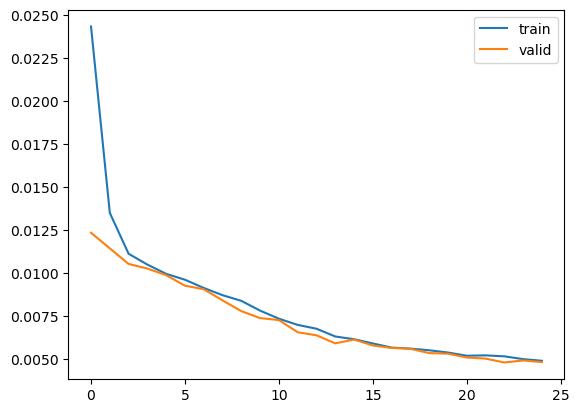

In [50]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

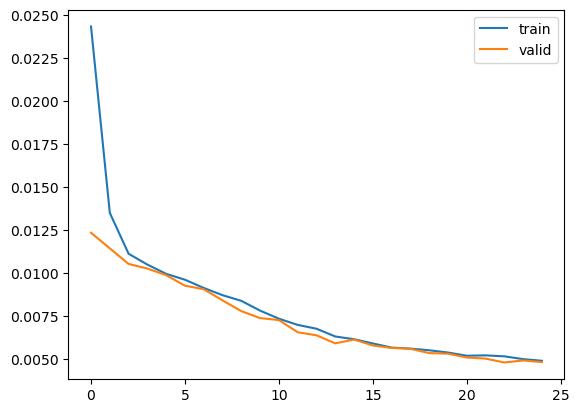

In [51]:
# base

plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [52]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        batch[nan]=0.0
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [53]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_linear = scaler.inverse_transform(test_madrid_normal)

In [54]:
recovery_nn['linear'] = test_linear

In [55]:
from sklearn.metrics import mean_squared_error

33403.67145810156


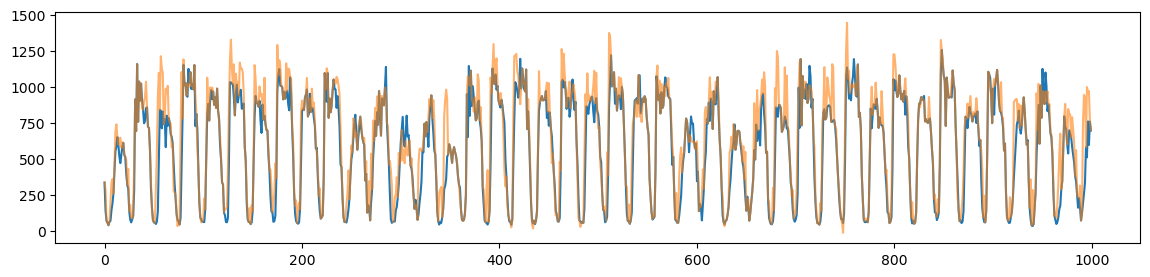

In [56]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_linear[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_linear[index].reshape(1,-1)))

33403.67145810156


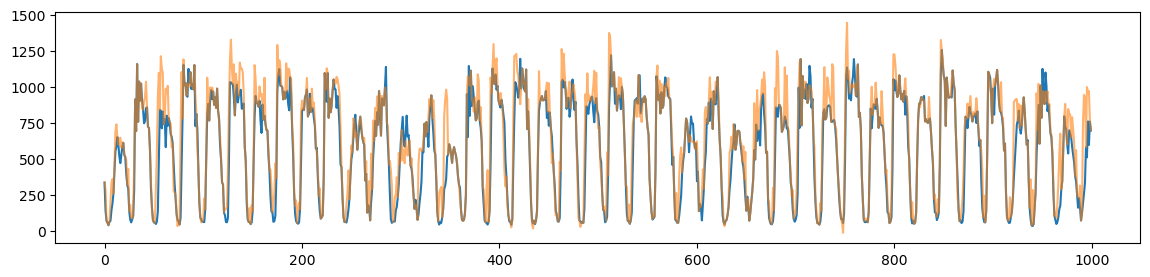

In [57]:
# base

fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_linear[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_linear[index].reshape(1,-1)))

##### 7.2.3 Реккурентная модель востановлениях данных


In [58]:
class EncoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=dim,
                          hidden_size=self.hidden_size)

        self.latten = nn.Linear(hidden_size*size_subsequent,latten_size)
        self.leaky = nn.LeakyReLU()
        self.fl = nn.Flatten()
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.leaky(x)
        #print(x.shape)
        x = self.fl(x)
        x = self.latten(x)
        return self.leaky(x)


In [59]:
class DecoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.latten_size=latten_size
        self.gru = nn.GRU(input_size=self.hidden_size,
                          hidden_size=dim)
        self.latten = nn.Linear(latten_size,hidden_size*size_subsequent)
        self.leaky = nn.LeakyReLU()

    def forward(self, x):
        x = self.latten(x)
        x = x.view(-1, self.size_subsequent, self.latten_size)
        x = self.leaky(x)
        x, _ = self.gru(x)
        return self.leaky(x)


In [60]:
class TimeAE(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.encoder = EncoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size)
        self.decoder = DecoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size)
    def forward(self, x):
        x=self.encoder(x)
        x = self.decoder(x)
        return x

In [61]:
model = TimeAE(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)


epochs = 25

In [62]:
model

TimeAE(
  (encoder): EncoderGRU(
    (gru): GRU(10, 100)
    (latten): Linear(in_features=10000, out_features=100, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
    (fl): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): DecoderGRU(
    (gru): GRU(100, 10)
    (latten): Linear(in_features=100, out_features=10000, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
  )
)

In [63]:
model=model.to(device)
train_history = []
valid_history = []
start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0]==batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            #
            X[torch.isnan(X)]=0.0
            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0]==batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                #
                X[torch.isnan(X)]=0.0
                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

epoch:1 train:0.026863858992255282, valid:0.011951227130931477
epoch:2 train:0.010705815556805253, valid:0.008249529507444349
epoch:3 train:0.00794743092452315, valid:0.006478918575530135
epoch:4 train:0.006830181300254731, valid:0.0059154972527898095
epoch:5 train:0.006074019413355781, valid:0.005258711091018924
epoch:6 train:0.005594060775891688, valid:0.004924506457999002
epoch:7 train:0.0051528439121998814, valid:0.004655512450479491
epoch:8 train:0.004807809092125845, valid:0.004366499180508445
epoch:9 train:0.004583708798312993, valid:0.004205548139505608
epoch:10 train:0.004288287463123371, valid:0.004018999950223884
epoch:11 train:0.00412611810890137, valid:0.0038514437944476686
epoch:12 train:0.003979593105935331, valid:0.0036843425626758228
epoch:13 train:0.00378252522060041, valid:0.003648042252879272
epoch:14 train:0.003684631685308855, valid:0.0034914243164970433
epoch:15 train:0.0035330112443673085, valid:0.0034561350836974473
epoch:16 train:0.0034117274239687857, valid:0

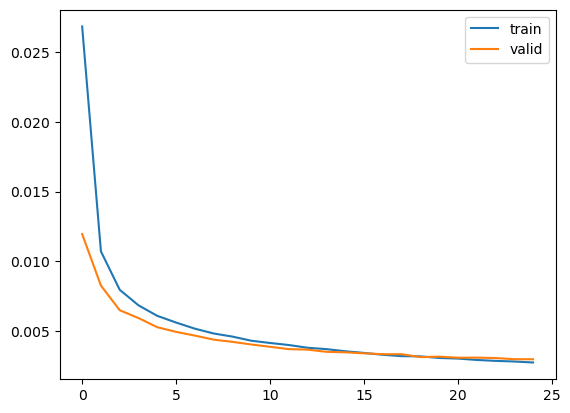

In [64]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [65]:
# base

model=model.to(device)
train_history = []
valid_history = []
start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0]==batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            #
            X[torch.isnan(X)]=0.0
            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0]==batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                #
                X[torch.isnan(X)]=0.0
                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

epoch:1 train:0.002655823905042362, valid:0.0028812848771525216
epoch:2 train:0.0025876933125372247, valid:0.002867776045012613
epoch:3 train:0.002598876942669923, valid:0.002839487630787284
epoch:4 train:0.002524900799652854, valid:0.002956171633762329
epoch:5 train:0.0025012748819058656, valid:0.002769067049632932
epoch:6 train:0.0024445833441162647, valid:0.0027505906782466774
epoch:7 train:0.0024023086253653543, valid:0.0027089305276181115
epoch:8 train:0.002396065348373919, valid:0.002690207953167747
epoch:9 train:0.002342339705005003, valid:0.0026433396680179493
epoch:10 train:0.002282900166148284, valid:0.0026365062492618033
epoch:11 train:0.00222309948599958, valid:0.0026386963246866715
epoch:12 train:0.0022300183224416843, valid:0.00260341608564752
epoch:13 train:0.0021711639378405394, valid:0.0025858078657310136
epoch:14 train:0.002188136379173832, valid:0.0026058226610829894
epoch:15 train:0.0021608893954020237, valid:0.0025993346962211437
epoch:16 train:0.002118397385445762

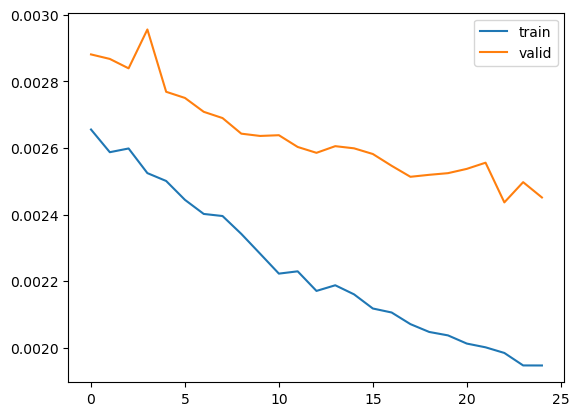

In [66]:
# base

plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [67]:
times_model['ae']=end-start

In [68]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        #
        batch[torch.isnan(batch)]=0.0
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [69]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_ae = scaler.inverse_transform(test_madrid_normal)

In [70]:
recovery_nn['test_ae'] = test_ae

12999.641340883616


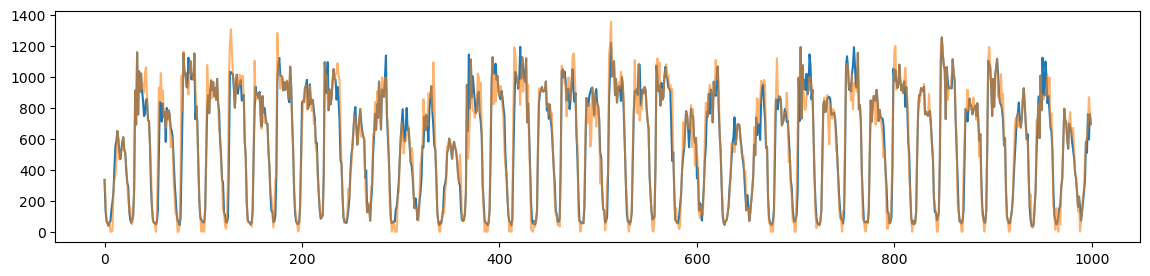

In [71]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_ae[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_ae[index].reshape(1,-1)))

12999.641340883616


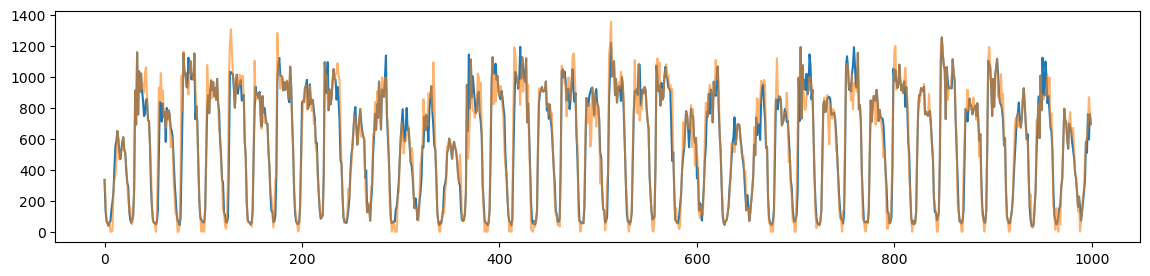

In [72]:
# base

fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_ae[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_ae[index].reshape(1,-1)))

##### 7.2.4 Сложные модели нейросетевого востановлениях данных


Вам необходимо выбрать одну модель из 3 группы таблицы 7.2 и используя документацию произвести восстановления того же ряда. Произведите замер времени.

In [73]:
!pip install pypots==0.0.9

  Obtaining dependency information for pypots==0.0.9 from https://files.pythonhosted.org/packages/9d/8d/d4503012afdc98a8b699d285ce220c07fb59af036959f5eca91b90e339e2/pypots-0.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for tensorboard from https://files.pythonhosted.org/packages/3a/d0/b97889ffa769e2d1fdebb632084d5e8b53fc299d43a537acee7ec0c021a3/tensorboard-2.16.2-py3-none-any.whl.metadata
  Obtaining dependency information for tsdb from https://files.pythonhosted.org/packages/91/b9/018fc52eb2cb6ccf441a840934d72a5133cccb925c483eca692c98e165c7/tsdb-0.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for absl-py>=0.4 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for grpcio>=1.48.2 from https://files.pythonhosted.org/packages/7b/3e/a22e7a0ec6be5454dc540063ac5d0843eb72a4641a0892b54b16b1438c0a/grpcio-1.60.1-cp311-cp311

In [74]:
from pypots.imputation import SAITS

In [75]:
model= SAITS(n_features=madrid.shape[1],
             n_steps=100,
             device=device,
             d_k=64,
             d_v=64,
             d_model=128,
             d_inner=128,
             n_head=4,
             n_layers=2,
             dropout=0.05,
             epochs=25)

Model initialized successfully. Number of the trainable parameters: 667608


In [76]:
start = time.time()
model.fit(train,test)
end = time.time()
times_model['saits']=end-start

epoch 0: training loss 0.2042, validating loss 0.0487
epoch 1: training loss 0.1221, validating loss 0.0381
epoch 2: training loss 0.1090, validating loss 0.0342
epoch 3: training loss 0.1023, validating loss 0.0332
epoch 4: training loss 0.0980, validating loss 0.0324
epoch 5: training loss 0.0950, validating loss 0.0323
epoch 6: training loss 0.0928, validating loss 0.0291
epoch 7: training loss 0.0911, validating loss 0.0277
epoch 8: training loss 0.0899, validating loss 0.0279
epoch 9: training loss 0.0751, validating loss 0.0273
epoch 10: training loss 0.0548, validating loss 0.0267
epoch 11: training loss 0.0536, validating loss 0.0272
epoch 12: training loss 0.0505, validating loss 0.0265
epoch 13: training loss 0.0493, validating loss 0.0266
epoch 14: training loss 0.0488, validating loss 0.0259
epoch 15: training loss 0.0483, validating loss 0.0269
epoch 16: training loss 0.0480, validating loss 0.0261
epoch 17: training loss 0.0476, validating loss 0.0269
epoch 18: training l

In [78]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
test_rolling_madrid = model.impute(test_rolling_madrid)

In [79]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_saits = scaler.inverse_transform(test_madrid_normal)

In [80]:
recovery_nn['saits'] = test_saits

7516.891861514798


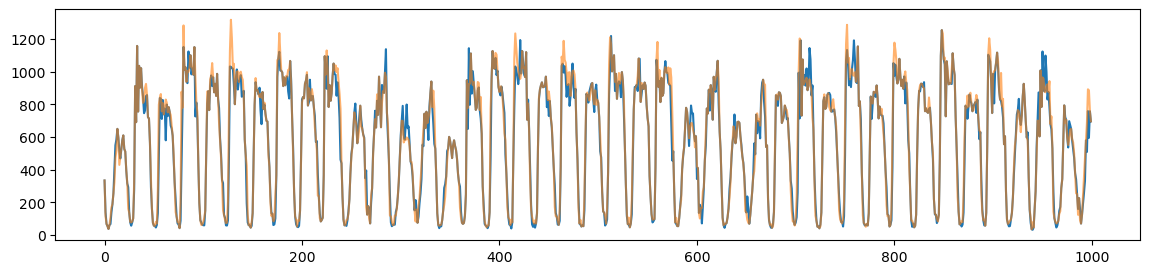

In [81]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_saits[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_saits[index].reshape(1,-1)))

##### 7.2.5 Сравнения результатов.
Также, как и в пункте 7.1.5 постройте графики сравнения моделей. Дополнительно постройте графики сравнения времени. Сделайте выводы

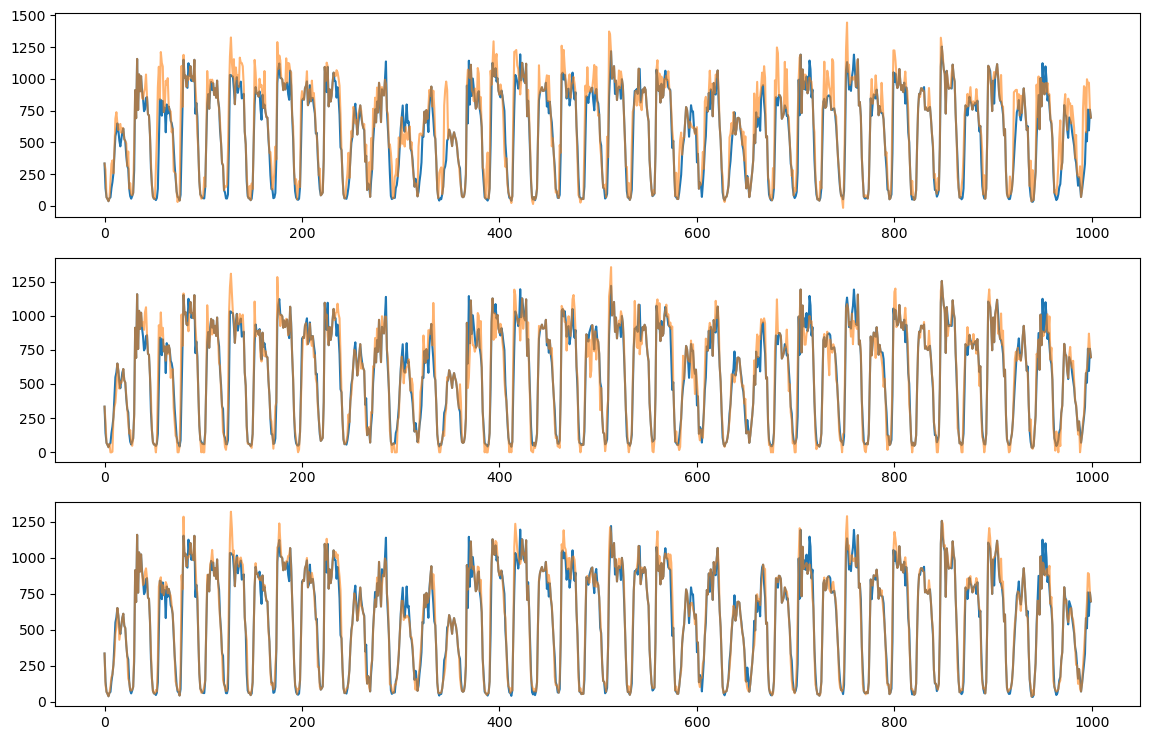

In [83]:
n = 3

fig, ax =  plt.subplots(figsize=(14,3*n),ncols=1,nrows=n)

ax[0].plot(madrid[:1000,0])
ax[0].plot(recovery_nn['linear'][:1000,0], alpha=0.6)

ax[1].plot(madrid[:1000,0])
ax[1].plot(recovery_nn['test_ae'][:1000,0], alpha=0.6)

ax[2].plot(madrid[:1000,0])
ax[2].plot(recovery_nn['saits'][:1000,0], alpha=0.6)

<BarContainer object of 3 artists>

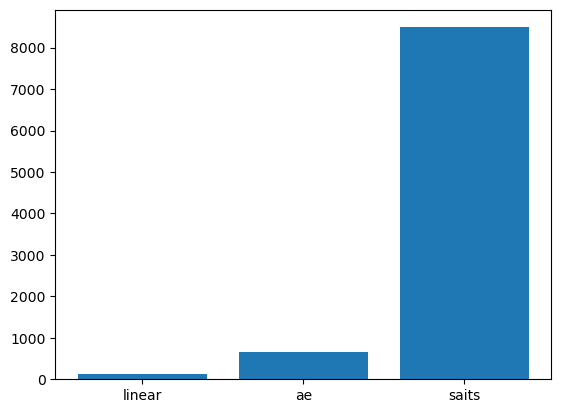

In [84]:
plt.bar(times_model.keys(), times_model.values())

#### **7.3 Прогноз временного ряда**

##### *Краткое описание*

Используя модель и [ARIMA](реализация) произвидите прогноз ряда на следующие колличество точек: 1, 5, 10.
Сравните результаты. Постройте графики прогноза и точности прогноза.

In [85]:
!pip install statsmodels

In [86]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(recovery_nn['saits'][:1000,0], order=(5,1,1))
model_fit = model.fit()

In [87]:
points_count = [1, 5, 10]
start_points = {1:234, 5:245, 10:256}

mse_err = {}
pred = {}

for i in points_count:
    pred[i] = model_fit.predict(start=start_points[i], end=start_points[i]+i-1)
    mse_err[i] = mean_squared_error(recovery_nn['saits'][start_points[i]:start_points[i]+i, 0], pred[i])

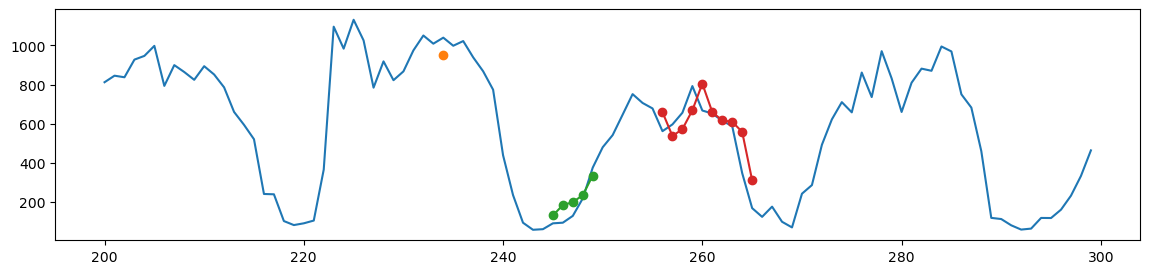

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,3))
plt.plot(range(200,300), recovery_nn['saits'][200:300, 0])
# colors = {1:}

for i in points_count:
    plt.plot(range(start_points[i], start_points[i]+i), pred[i], marker='o')

In [89]:
mse_err

{1: 8027.4466306128, 5: 3301.7384397549445, 10: 11881.928378131648}